# Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from glob import glob
from pathlib import Path
import time

# Load & Preprocess Data

In [2]:
men_paths = glob(r"Data\man\*")
women_paths = glob(r"Data\woman\*")

In [3]:
men_imgs = np.array([tf.cast(np.array(Image.open(path).resize((260,260))),tf.float32) for path in men_paths])
women_imgs = np.array([tf.cast(np.array(Image.open(path).resize((260,260))),tf.float32) for path in women_paths])

In [4]:
men_imgs.shape

(100, 260, 260, 3)

In [7]:
imgs = np.concatenate([women_imgs,men_imgs])
labels = np.concatenate([np.zeros((len(women_imgs),1)),np.ones((len(men_imgs),1))])

In [8]:
imgs.shape

(200, 260, 260, 3)

In [64]:
BATCH_SIZE = 15
dataset = tf.data.Dataset.from_tensor_slices((imgs,labels)).shuffle(100).shuffle(150)
train_set = dataset.take(150).shuffle(50).batch(BATCH_SIZE)
valid_set = dataset.skip(150).take(20).batch(BATCH_SIZE)
test_set = dataset.skip(170).batch(BATCH_SIZE)

In [39]:
tf.data.experimental.cardinality(train_set)

<tf.Tensor: shape=(), dtype=int64, numpy=10>

# Build & Train Model

In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.layers import Dense,GlobalAvgPool2D,Dropout
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

In [41]:
base_model = EfficientNetB2()
base_model.load_weights(r"EfficientNetB2_Weights.h5")

In [42]:
base_model.trainable = False

In [43]:
avg = GlobalAvgPool2D()(base_model.layers[-4].output)
dropout = Dropout(0.2)(avg)
out = Dense(1,sigmoid)(dropout)
model = Model(inputs = [base_model.input],outputs = [out])

In [44]:
model.compile(loss = 'binary_crossentropy',
              optimizer= Nadam(),
              metrics = ['accuracy'])

In [45]:
# Tensorboard Initialization to track training if needed(I am not using it right now)
def get_run_logdir(root_logdir="my_logs"):
 return Path(root_logdir) / time.strftime("run_%Y_%m_%d_%H_%M_%S")
tensorboard_cb = TensorBoard(get_run_logdir(),
 profile_batch=(100, 200),histogram_freq=1)

In [46]:
early_stopping_cb = EarlyStopping(patience=2,restore_best_weights=True)

In [47]:
history = model.fit(train_set,epochs = 10,validation_data=valid_set,callbacks = [early_stopping_cb])

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5793 - loss: 0.6906 - val_accuracy: 0.7500 - val_loss: 0.6238
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 985ms/step - accuracy: 0.7988 - loss: 0.5629 - val_accuracy: 0.9000 - val_loss: 0.4850
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 967ms/step - accuracy: 0.8988 - loss: 0.4700 - val_accuracy: 0.9000 - val_loss: 0.3947
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 990ms/step - accuracy: 0.9332 - loss: 0.3815 - val_accuracy: 0.9500 - val_loss: 0.3129
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 985ms/step - accuracy: 0.9541 - loss: 0.3114 - val_accuracy: 1.0000 - val_loss: 0.2396
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 963ms/step - accuracy: 0.9648 - loss: 0.2618 - val_accuracy: 0.9500 - val_loss: 0.2184
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 935ms/step - accuracy: 0.9757 - loss: 0.2094 - val_accuracy: 0.9500 - val_loss: 0.2520
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9466 - loss: 0.2107 - val_accuracy: 0

<Axes: >

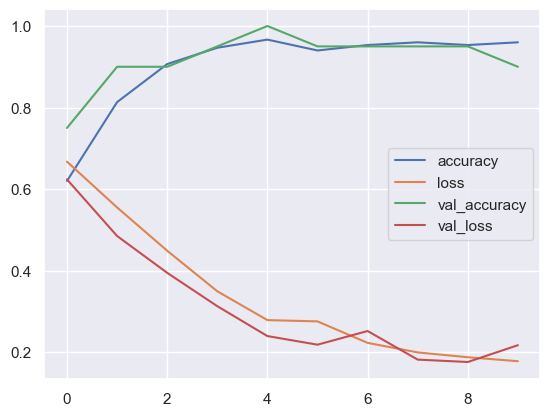

In [53]:
pd.DataFrame(history.history).plot()

In [65]:
model.evaluate(test_set)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 1.0000 - loss: 0.1643


[0.1681300848722458, 1.0]

In [68]:
# Save Model
model.save(r'gender_recognizer.keras')